$ \theta = \{\psi, \sigma \} $

$\psi$: Parametros para definição do modelo que será utilizado em cada estado<br>
$\sigma$: Parametros para cada Modelo $\{\sigma_1, \sigma_2, ...\}$ <br>

$ \beta: S \mapsto [0,1]^k \;\; onde \;\; k = |\sigma|$ <br>
$ \beta(s; \psi)_i = p_{\psi}(\sigma_i | s) \; \forall \; i \in (1, 2, ..., k)$ <br>
A função $ \beta $ define a probabilidade de cada parametro em $ \sigma $ ser o modelo utilizado pra gerar a transição em um estado <br>

$\mu: S \times S \times A \times \sigma \mapsto [0,1] $ <br>
$\mu(s', s, a, \sigma_x)= p_{\sigma_x}(s'|s,a)$ <br>
A função $ \mu $ define a probabilidade de transição para um estado, dado um par de estado e ação, seguindo o modelo $\sigma_x$ <br>

In [1]:
import numpy as np
import random

force = .5
actions = np.array([(force,0), (-force,0), (0,force), (0,-force)])
theta = [5, (.005,.3)]

def mu(s, a, p=2):
    acts = actions[a]
    return s + acts + np.random.normal(0, p, 2)

def beta(x,y):
    psi, _ = theta
    return 1*((x**2 + y**2)**(1/2) < psi)

def generate(s0, n):   
    _, sigma = theta
    s = s0
    for _ in range(n):
        a = np.random.choice(4, 1)[0]
        m = beta(s[:,0], s[:,1])[0]
        sa = np.insert(s, s.size, a)
        yield np.insert(sa, sa.size, m)
        s = mu(s, a, sigma[m])

# def trajectory(s_0=(1,1), n=100):
#     gen = generate(s_0, n)
#     return np.fromiter(gen, dtype=np.dtype((float, 4)))

# s_0 = np.array([[0,0]])
# n = 1000

# O = trajectory(s_0, n)
# O[:] # all
# O[:,0:2] # states
# O[:,2] # actions
# O[:,3] # hidden models


In [2]:
import pandas as pd

def generate_data(trajectory_size=1000, n_trajectories=10, s_0=(0,0)):
    s_0 = np.array([s_0])
    gen = generate(s_0, 1)
    sx,sy,a,m = next(gen)
    df = pd.DataFrame({
        'n':[0],
        't':[0],
        's':[(sx,sy)],
        'a':[int(a)],
        'm':[int(m)]
        })

    for i in range(n_trajectories):
        gen = generate(s_0, trajectory_size)
        for t,(sx,sy,a,m) in enumerate(gen):
            df.loc[len(df.index)] = [int(i),int(t),(sx,sy),int(a),int(m)]

    df.drop(0, inplace=True)
    return df

df = generate_data() 
df.head()

,n,t,s,a,m
1,0,0,"(0, 0)",0,1
2,0,1,"(0.9593143300856022, -0.36087116313132533)",0,1
3,0,2,"(1.7862005655504916, -0.9232002328426991)",3,1
4,0,3,"(1.6256455712650908, -1.47693456320199)",1,1
5,0,4,"(1.6587186413491648, -1.6977982848623874)",0,1


<AxesSubplot: >

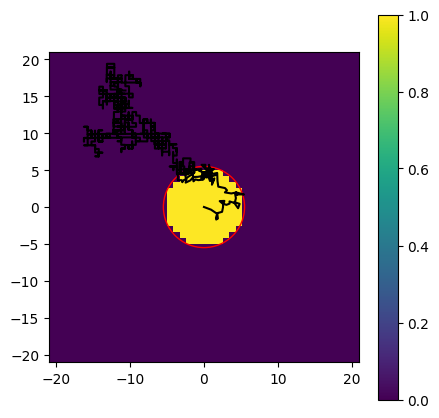

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_trajectory(data, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    # ax.invert_yaxis()

    size = 20
    res = 50
    x = np.linspace(-size, size, res).reshape(-1,1)
    y = np.linspace(-size, size, res).reshape(-1,1)

    X,Y = np.meshgrid(x,y)
    p = ax.imshow(beta(X,Y), extent=(int(min(x))-1, int(max(x))+1, int(max(y))+1, int(min(y))-1), vmin = 0, vmax = 1)
    plt.colorbar(p)
    ax.invert_yaxis()

    df_s = pd.DataFrame(data.s.to_list(), columns=['x','y'])
    ax.plot(df_s.x, df_s.y, color='black')
    ax.add_patch(Circle((0, 0), theta[0]+force, edgecolor='red', fill=False))
    return ax

plot_trajectory(df[df.n==0])

In [4]:
import torch
from torch.autograd import Variable
from torch.distributions import normal
import torch.nn as nn
import torch.nn.functional as f

class BetaModel(nn.Module):
    def __init__(self):
        super(BetaModel, self).__init__()
        n_features = 2
        n_models = 2
        n_hidden = 10

        self.model = nn.Sequential(
            nn.Linear(n_features, n_hidden).double(),
            nn.ReLU(),
            # nn.Linear(n_hidden, n_hidden).double(),
            # nn.ReLU(),
            nn.Linear(n_hidden, n_models).double(),
            nn.ReLU(),
            nn.Softmax(dim=1)
            # nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        return self.model(x)

In [5]:
# sig = theta[1][0]

# acts = np.stack((
#     np.take(actions[:,0], df.loc[df.n==0].a.iloc[:-1]), 
#     np.take(actions[:,1], df.loc[df.n==0].a.iloc[:-1])
# ), axis=-1)

# s = torch.from_numpy(df.loc[df.n==0]['s'].iloc[:-1].apply(pd.Series).to_numpy()).type(torch.DoubleTensor)[-1:]
# a = torch.from_numpy(acts).type(torch.DoubleTensor)[-1:]
# s_ = torch.from_numpy(df.loc[df.n==0]['s'].iloc[1:].apply(pd.Series).to_numpy()).type(torch.DoubleTensor)[-1:]

# # torch.clamp(torch.exp(normal.Normal(s[:,0] + a[:,0], sig).log_prob(s_[:,0])) * torch.exp(normal.Normal(s[:,1] + a[:,1], sig).log_prob(s_[:,1])), min=1e-50, max=1)
# print(
#     s[:,0].item(),
#     a[:,0].item(),
#     s_[:,0].item(),
# )
# print(
#     theta[1][0],
#     (normal.Normal(s[:,0] + a[:,0], theta[1][0]).cdf(s_[:,0]+1e-10) - normal.Normal(s[:,0] + a[:,0], theta[1][0]).cdf(s_[:,0]-1e-10)) .item(), 
#     normal.Normal(s[:,0] + a[:,0], theta[1][0]).log_prob(s_[:,0]).item(), 
#     torch.exp(normal.Normal(s[:,0] + a[:,0], theta[1][0]).log_prob(s_[:,0])).item(), 
#     theta[1][1],
#     (normal.Normal(s[:,0] + a[:,0], theta[1][1]).cdf(s_[:,0]+1e-10) - normal.Normal(s[:,0] + a[:,0], theta[1][1]).cdf(s_[:,0]-1e-10)).item(),
#     normal.Normal(s[:,0] + a[:,0], theta[1][1]).log_prob(s_[:,0]).item(),
#     torch.exp(normal.Normal(s[:,0] + a[:,0], theta[1][1]).log_prob(s_[:,0])).item()
# )
# print(
#     s[:,1].item(),
#     a[:,1].item(),
#     s_[:,1].item(),
# )
# print(
#     theta[1][0],
#     (normal.Normal(s[:,1] + a[:,1], theta[1][0]).cdf(s_[:,1]+1e-10) - normal.Normal(s[:,1] + a[:,1], theta[1][0]).cdf(s_[:,1]-1e-10)).item(), 
#     normal.Normal(s[:,1] + a[:,1], theta[1][0]).log_prob(s_[:,1]).item(), 
#     torch.exp(normal.Normal(s[:,1] + a[:,1], theta[1][0]).log_prob(s_[:,1])).item(), 
#     theta[1][1],
#     (normal.Normal(s[:,1] + a[:,1], theta[1][1]).cdf(s_[:,1]+1e-10) - normal.Normal(s[:,1] + a[:,1], theta[1][1]).cdf(s_[:,1]-1e-10)).item(),
#     normal.Normal(s[:,1] + a[:,1], theta[1][1]).log_prob(s_[:,1]).item(),
#     torch.exp(normal.Normal(s[:,1] + a[:,1], theta[1][1]).log_prob(s_[:,1])).item()
# )

   

In [6]:
def loglike(beta, data):
    def prob(sig):
        acts = np.stack((
            np.take(actions[:,0], data.a.iloc[:-1]), 
            np.take(actions[:,1], data.a.iloc[:-1])
        ), axis=-1)

        s = torch.from_numpy(data['s'].iloc[:-1].apply(pd.Series).to_numpy()).type(torch.DoubleTensor)
        a = torch.from_numpy(acts).type(torch.DoubleTensor)
        s_ = torch.from_numpy(data['s'].iloc[1:].apply(pd.Series).to_numpy()).type(torch.DoubleTensor)
        
        # return torch.exp(normal.Normal(s[:,0] + a[:,0], sig).log_prob(s_[:,0])) * torch.exp(normal.Normal(s[:,1] + a[:,1], sig).log_prob(s_[:,1]))
        # return torch.clamp(torch.exp(normal.Normal(s[:,0] + a[:,0], sig).log_prob(s_[:,0])) * torch.exp(normal.Normal(s[:,1] + a[:,1], sig).log_prob(s_[:,1])), min=1e-50, max=1)
        # return torch.clamp(
        return torch.exp(normal.Normal(s[:,0] + a[:,0], sig).log_prob(s_[:,0])) * torch.exp(normal.Normal(s[:,1] + a[:,1], sig).log_prob(s_[:,1]))
        # return (
        #     (normal.Normal(s[:,0] + a[:,0], sig).cdf(s_[:,0]+1e-10) - normal.Normal(s[:,0] + a[:,0], sig).cdf(s_[:,0]-1e-10)) * 
        #     (normal.Normal(s[:,1] + a[:,1], sig).cdf(s_[:,1]+1e-10) - normal.Normal(s[:,1] + a[:,1], sig).cdf(s_[:,1]-1e-10)))
        #     # , min=1e-50, max=1)
    
    mi = torch.stack([prob(sig) for sig in theta[1]], dim=1)
    # p_theta = torch.sum((mi * torch.clamp(beta, min=1e-50, max=1)), 1) 
    p_theta = torch.sum((mi * beta), 1) 
    # p_theta = torch.sum((mi * np.clip(beta, a_min=1e-50, a_max=1)), 1) 

    return -torch.sum(torch.log(p_theta))


# df_teste = df.loc[df.n==0].iloc[:-1].copy()
# df_teste['m2'] = 1-df_teste.m
# loglike(torch.from_numpy(df_teste[['m2', 'm']].to_numpy()), df.loc[df.n==0])


In [7]:
# i = 0

# ideal = loglike(
#     torch.from_numpy(np.stack((1-df.loc[df.n==i].iloc[:-1].m.to_numpy(), df.loc[df.n==i].iloc[:-1].m.to_numpy()), axis=-1)),
#     df.loc[df.n==i]
# ).item()

# constante = loglike(
#     # torch.from_numpy(np.stack((np.ones(df[df.n==i].shape[0]-1), np.zeros(df[df.n==i].shape[0]-1)), axis=-1)).type(torch.DoubleTensor),
#     torch.from_numpy(np.stack((np.zeros(df[df.n==i].shape[0]-1), np.ones(df[df.n==i].shape[0]-1)), axis=-1)).type(torch.DoubleTensor),
#     df.loc[df.n==i]
# ).item()

# print("ideal    : ", ideal)
# print("constante: ", constante)

In [8]:

def train(model, data, epochs=1000, log=False):
    # x_train_tensor = torch.tensor(data.s.to_list()).type(torch.DoubleTensor)
    # x_train_tensor = torch.tensor(data.s.iloc[:-1].to_list()).type(torch.DoubleTensor)
    x_train_tensor = torch.tensor(data['s'].iloc[:-1].apply(pd.Series).to_numpy()).type(torch.DoubleTensor)
    # y_train_tensor = torch.from_numpy(np.array(data.m)).type(torch.LongTensor)

    optim = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=.9)
    # loss = nn.MSELoss(reduction='mean')
    # loss = nn.CrossEntropyLoss()
    # loss = nn.NLLLoss(reduction='sum')
    loss = loglike

    def do_train(epoch):
        optim.zero_grad()
        outputs = model(x_train_tensor)
        ll = loss(outputs, data)
        if log:
            print(epoch, ll.item())
        ll.backward()
        optim.step() 
        return ll.item()

    model.train(True)
    lls = [do_train(epoch) for epoch in range(epochs)]
    model.train(False)

    return lls


# torch.manual_seed(0)
# log = True
# def train_models(data, n_models=10):
#     models = [BetaModel() for _ in range(n_models)]
#     results = [train(model, data, log=log) for model in models]
#     return models, results
# mod, res = train_models(df[df.n==0], 1)
# res

In [9]:
def train_models(data, n_models=10):
    models = [BetaModel() for _ in range(n_models)]
    results = [train(model, data) for model in models]
    return models, results

n = 10 
m = 5
models = []
results = []
for i in range(n):
    mod, res = train_models(df[df.n==i], m)
    models.append(mod)
    results.append(res)

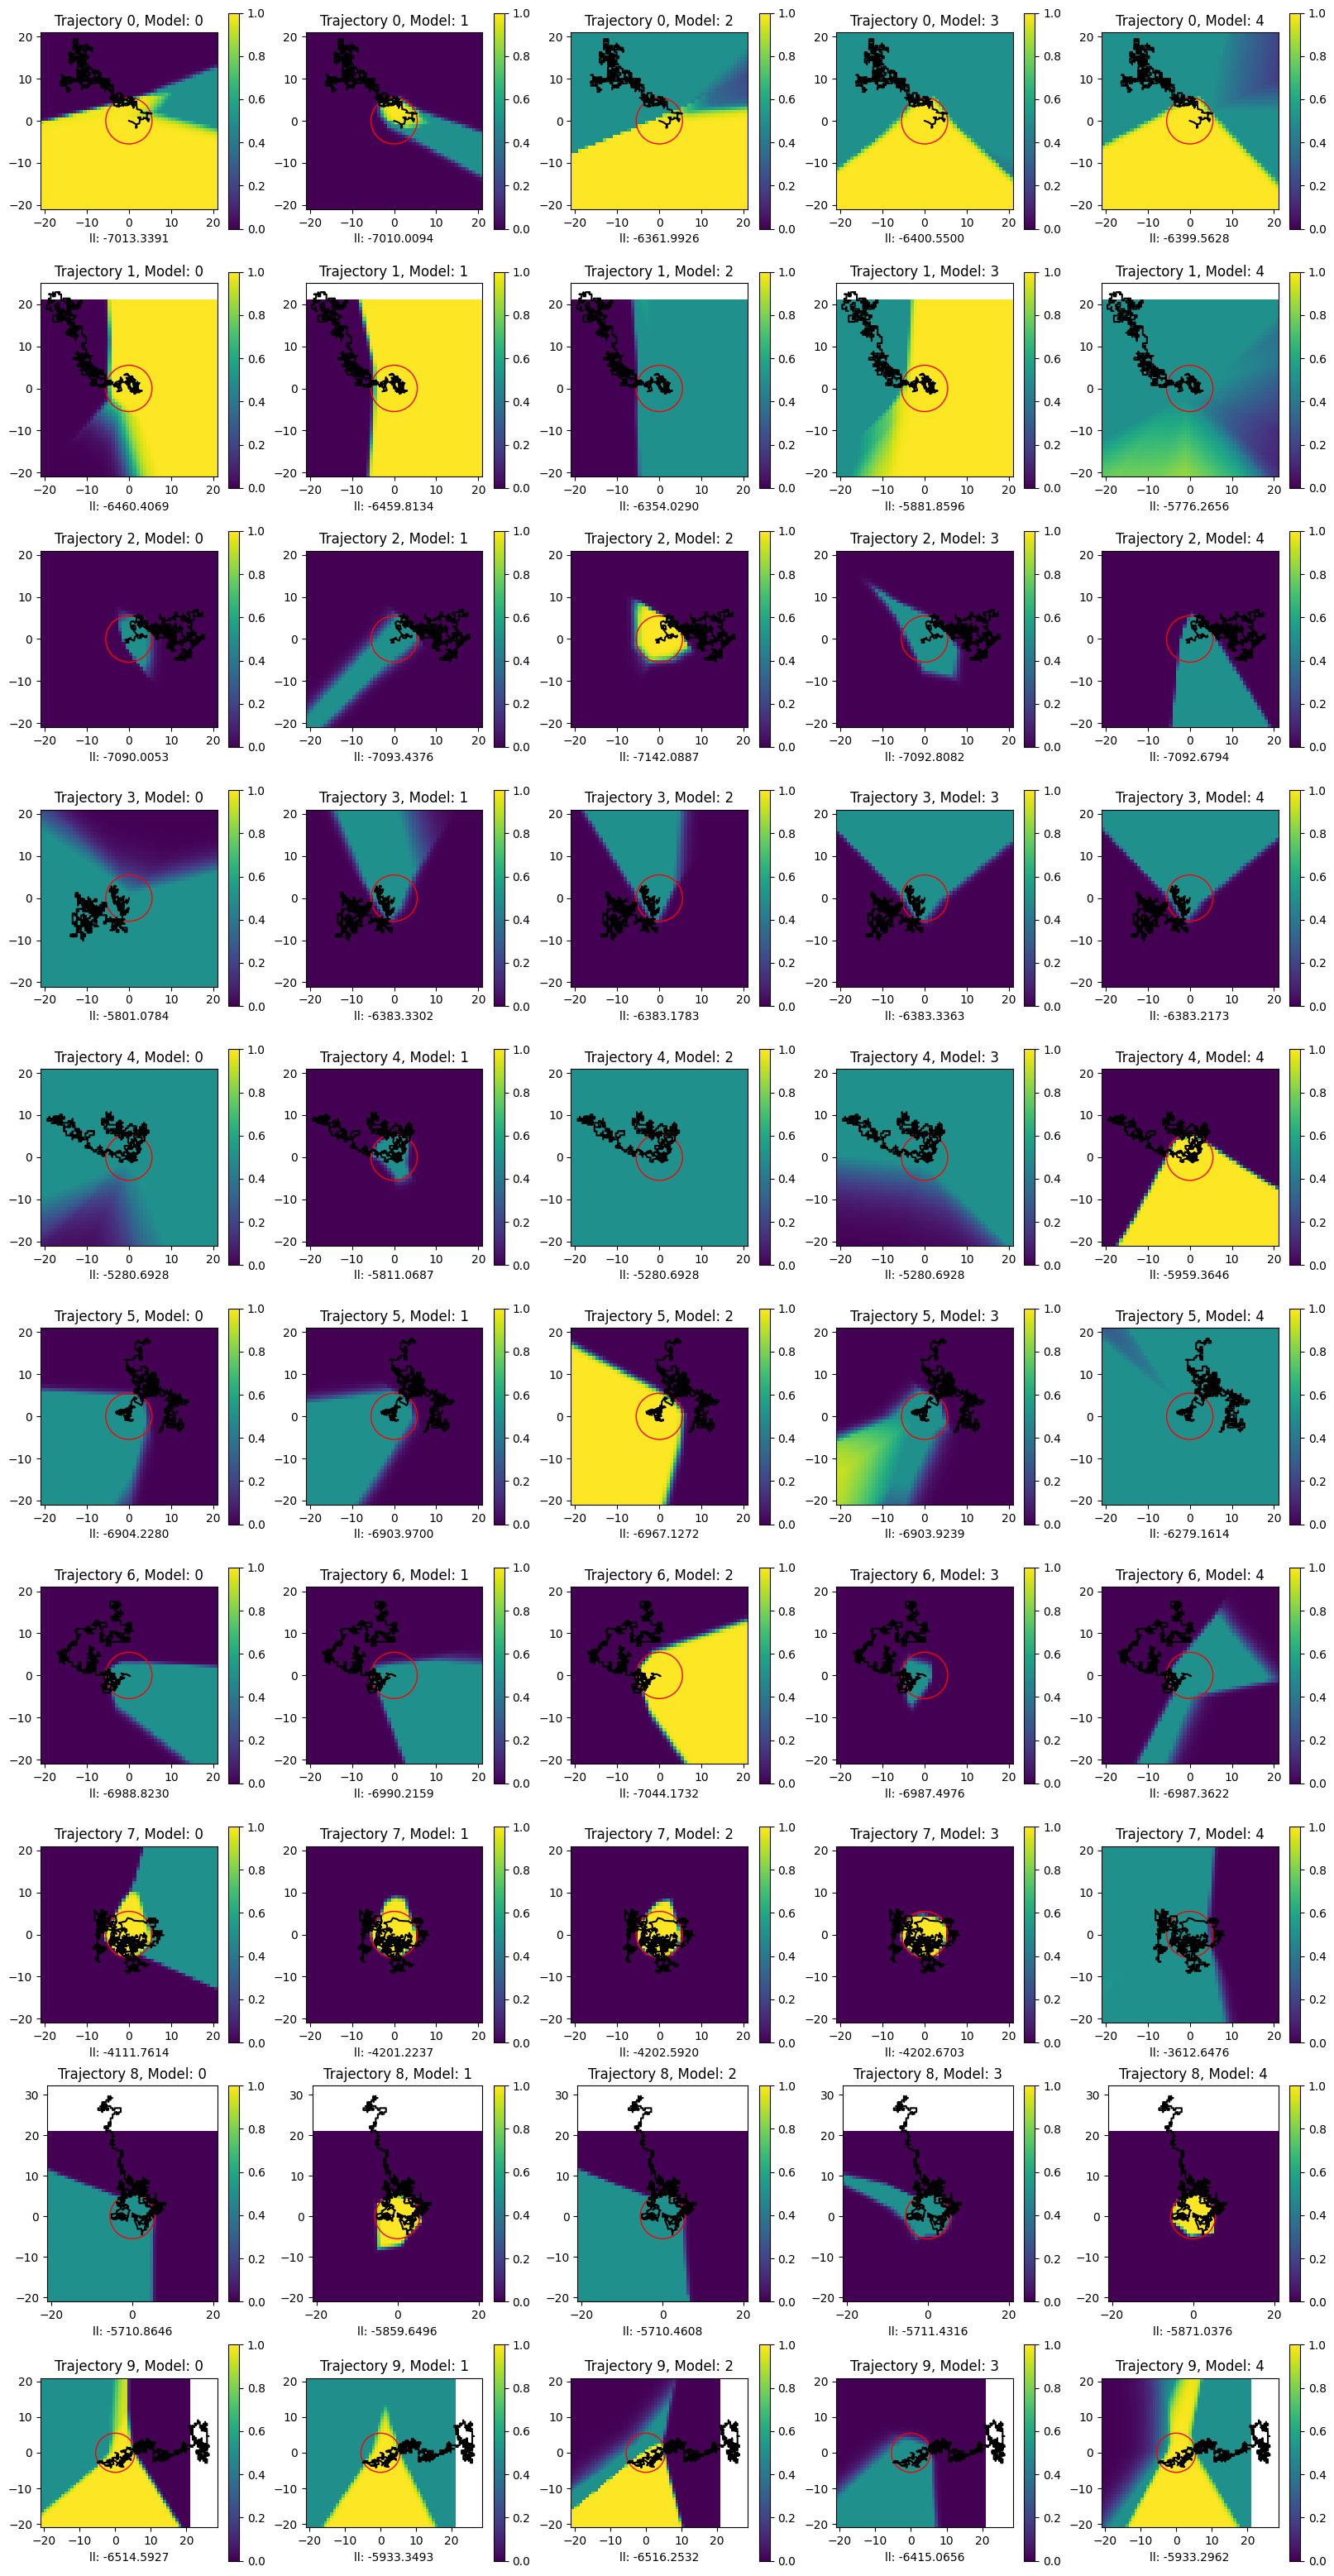

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_test(data, t=None, n=None):
    if t is None:
        ts = range(len(models))
    else:
        ts = [t]

    if n is None:
        ms = range(len(models[ts[0]]))
    else:
        ms = [n]

    # fig = plt.figure(1, figsize=(5, 5*len(ms)))
    fig, axs = plt.subplots(len(ts), len(ms), figsize=(4*len(ms), (4*len(ts))))
    if len(ts)==1:
        axs = [axs]
    if len(ms)==1:
        axs = [[a] for a in axs]

    
    size = 20
    res = 50
    lin = np.linspace(-size, size, res).reshape(-1,1)
    X,Y = np.meshgrid(lin, lin)

    d = np.stack((X, Y), axis=-1).reshape(-1, 2)
    d = torch.from_numpy(d).type(torch.DoubleTensor)
    
    for row, t in zip(axs, ts):
        df_s = pd.DataFrame(data[data.n==t].s.to_list(), columns=['x','y'])
        
        for ax, m in zip(row, ms):
            ax.set_title(f'Trajectory {t}, Model: {m}')
            corr = models[t][m](d)[:,1].reshape(int(X.size**(1/2)), int(X.size**(1/2)))
            with torch.no_grad():
                p = ax.imshow(corr, extent=(int(min(lin))-1, int(max(lin))+1, int(max(lin))+1, int(min(lin))-1), vmin = 0, vmax = 1)
                plt.colorbar(p)
            ax.invert_yaxis()
            ax.set_xlabel(f'll: {results[t][m][-1]:.4f}')
            ax.plot(df_s.x, df_s.y, color='black')
            ax.add_patch(Circle((0, 0), theta[0]+force, edgecolor='red', fill=False))



plot_test(df)
# plot_test(df, 0)
# plot_test(df, 0,0)

In [11]:
df_results = pd.DataFrame({
    "n": [i for i,values in enumerate(results) for _ in values],
    "nn": [j for _,values in enumerate(results) for j,_ in enumerate(values)],
    # "ll": [v.item() for values in results for v in values],
    "ll": [v[-1] for values in results for v in values],
    "ll_ideal": [loglike(
            torch.from_numpy(np.stack((1-df.loc[df.n==i].iloc[:-1].m.to_numpy(), df.loc[df.n==i].iloc[:-1].m.to_numpy()), axis=-1)),
            df.loc[df.n==i]
        ).item() for i,values in enumerate(results) for j,v in enumerate(values)],
    "ll_const": [loglike(
            # torch.from_numpy(np.stack((np.ones(df[df.n==i].shape[0]-1), np.zeros(df[df.n==i].shape[0]-1)), axis=-1)).type(torch.DoubleTensor),
            torch.from_numpy(np.stack((np.zeros(df[df.n==i].shape[0]-1), np.ones(df[df.n==i].shape[0]-1)), axis=-1)).type(torch.DoubleTensor),
            df.loc[df.n==i]
        ).item() for i,values in enumerate(results) for _,_ in enumerate(values)],
})

df_results.head(10)

,n,nn,ll,ll_ideal,ll_const
0,0,0,-7013.339064,-7036.595536,-476.844015
1,0,1,-7010.009369,-7036.595536,-476.844015
2,0,2,-6361.992635,-7036.595536,-476.844015
3,0,3,-6400.549959,-7036.595536,-476.844015
4,0,4,-6399.562768,-7036.595536,-476.844015
5,1,0,-6460.406871,-6466.172979,-416.783855
6,1,1,-6459.813351,-6466.172979,-416.783855
7,1,2,-6354.028959,-6466.172979,-416.783855
8,1,3,-5881.859601,-6466.172979,-416.783855
9,1,4,-5776.265637,-6466.172979,-416.783855


In [12]:
df_agg = df_results[['n', 'll']].groupby('n').agg(['mean', 'median', 'std', 'min', 'max'])
df_agg

ll                                                   
          mean       median         std          min          max
n                                                                
0 -6637.090759 -6400.549959  342.301458 -7013.339064 -6361.992635
1 -6186.474884 -6354.028959  331.243534 -6460.406871 -5776.265637
2 -7102.203844 -7092.808186   22.335208 -7142.088700 -7090.005288
3 -6266.828094 -6383.217347  260.361986 -6383.336252 -5801.078431
4 -5522.502328 -5280.692793  335.236752 -5959.364566 -5280.692793
5 -6791.682091 -6903.970018  287.807169 -6967.127198 -6279.161358
6 -6999.614386 -6988.822991   24.935969 -7044.173242 -6987.362155
7 -4066.178991 -4201.223655  256.536500 -4202.670277 -3612.647620
8 -5772.688826 -5711.431557   84.678327 -5871.037603 -5710.460822
9 -6262.511374 -6415.065584  303.287406 -6516.253160 -5933.296155

In [13]:
df_results[df_results.n==5]

,n,nn,ll,ll_ideal,ll_const
25,5,0,-6904.228027,-6969.723017,-466.52992
26,5,1,-6903.970018,-6969.723017,-466.52992
27,5,2,-6967.127198,-6969.723017,-466.52992
28,5,3,-6903.923852,-6969.723017,-466.52992
29,5,4,-6279.161358,-6969.723017,-466.52992


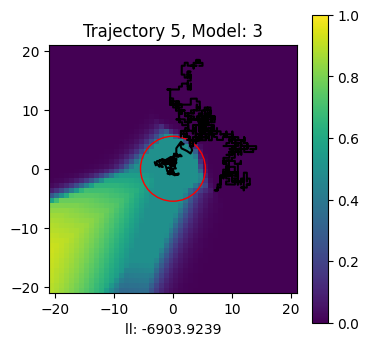

In [14]:
plot_test(df, 5,3)

In [15]:
df_results['dist'] = df_results.ll-df_results.ll_ideal
df_results[['dist', 'n']].groupby('n').agg(['mean', 'median', 'std', 'min', 'max'])

dist                                                
         mean      median         std         min         max
n                                                            
0  399.504777  636.045576  342.301458   23.256471  674.602901
1  279.698095  112.144020  331.243534    5.766108  689.907342
2   49.483332   58.878990   22.335208    9.598476   61.681887
3  225.194603  108.805350  260.361986  108.686445  690.944265
4  445.975796  687.785331  335.236752    9.113558  687.785331
5  178.040926   65.752999  287.807169    2.595819  690.561658
6   52.061750   62.853146   24.935969    7.502894   64.313982
7  149.133562   14.088898  256.536500   12.642275  602.664932
8  116.464607  177.721876   84.678327   18.115830  178.692611
9  261.186326  108.632116  303.287406    7.444540  590.401545

In [16]:
df_results['relativ'] = df_results.ll/df_results.ll_ideal
df_results[['relativ', 'n']].groupby('n').agg(['mean', 'median', 'std', 'min', 'max'])

relativ                                        
       mean    median       std       min       max
n                                                  
0  0.943225  0.909609  0.048646  0.904129  0.996695
1  0.956744  0.982657  0.051227  0.893305  0.999108
2  0.993081  0.991767  0.003123  0.991375  0.998658
3  0.965312  0.983240  0.040105  0.893570  0.983258
4  0.925278  0.884764  0.056168  0.884764  0.998473
5  0.974455  0.990566  0.041294  0.900920  0.999628
6  0.992617  0.991087  0.003536  0.990880  0.998936
7  0.964621  0.996658  0.060858  0.857030  0.997001
8  0.980224  0.969822  0.014379  0.969657  0.996924
9  0.959963  0.983348  0.046490  0.909499  0.998859

: 